<center><h1>SoundCloud Crawling data</h1></center>

## Import libraries

In [1]:
import requests
import requests_cache
import time
import json
import re
import pandas as pd 
from datetime import datetime, timedelta 
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from transformers import pipeline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Generating function for system actions

In [2]:
def scroll_down(driver):
    time.sleep(1)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

def get_elements(driver, by, name, delay=2, first=False, tries=5):
    while tries > 0:
        try:
            elem = None
            if first:
                elem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((by, name)))
            else:
                elem = WebDriverWait(driver, delay).until(EC.presence_of_all_elements_located((by, name)))
            return elem
        except TimeoutException:
            tries-=1

Generating data collection

In [3]:
def get_info(driver, list_users_link, users):
    driver.execute_script("window.open('');")
    driver.switch_to.window(driver.window_handles[1])
    for link, id in list_users_link.items():
        driver.get(link)
        users['id'].append(id)
        name = 'infoStats__value'
        elements = get_elements(driver, By.CLASS_NAME, name)
        try:
            users['name'].append(get_elements(driver, By.CLASS_NAME, 'profileHeaderInfo__userName', first=True).text)
        except:
            users['name'].append(None)
        attrs = ['followers', 'following', 'tracks']
        for i in range(len(attrs)):
            try:
                users[attrs[i]].append(elements[i].text)
            except:
                users[attrs[i]].append(None)
        
    driver.close()
    driver.switch_to.window(driver.window_handles[0])

def get_users(driver, link, tracks, tracks_id, list_users_link, list_tracks_link):
    global user_id
    global track_id
    driver.execute_script("window.open('');")
    driver.switch_to.window(driver.window_handles[2])
    driver.get(link)
    name = 'sc-ministats-item'
    elements = get_elements(driver, By.CLASS_NAME, name)
    if link in list_tracks_link.keys():
        tracks_id.append(str(list_tracks_link[link]))
    else:
        track_id += 1
        tracks['id'].append(track_id)
        tracks_id.append(str(track_id))
        author = get_elements(driver, By.CLASS_NAME, 'sc-link-secondary', first=True)
        link = author.get_attribute('href')
        if link in list_users_link.keys():
            tracks['author'].append(list_users_link[link])
        else:
            user_id += 1
            tracks['author'].append(user_id)
            list_users_link[link] = user_id
        try:
            tracks['title'].append(get_elements(driver, By.CLASS_NAME, 'soundTitle__title', first=True).text)
        except:
            tracks['title'].append(None)
        attrs = ['plays', 'likes', 'reposts']
        for i in range(len(attrs)):
            try:
                tracks[attrs[i]].append(elements[i].get_attribute('title').split(' ')[0])
            except:
                tracks[attrs[i]].append('0')
        tracks['release'].append(get_elements(driver, By.CLASS_NAME, 'relativeTime', first=True).text)
    driver.close()
    driver.switch_to.window(driver.window_handles[1])

def get_tracks(driver, link, tracks, tracks_id, list_users_link, list_tracks_link):
    driver.execute_script("window.open('');")
    driver.switch_to.window(driver.window_handles[1])
    driver.get(link)
    name = 'trackItem__trackTitle'
    elements = get_elements(driver, By.CLASS_NAME, name)
    cnt = 0
    # crawl 2 tracks of playlist
    for e in elements:
        cnt += 1
        link = e.get_attribute('href')
        get_users(driver, link, tracks, tracks_id, list_users_link, list_tracks_link)
        if cnt == 2:
            break
    driver.close()
    driver.switch_to.window(driver.window_handles[0])

def get_playlists(driver, elements, playlists, tracks, list_users_link, list_tracks_link):
    global playlist_id
    global user_id
    for e in elements:
        # pass unavailable and less than 5 tracks
        data = e.text.split('\n')
        link = e.find_element(By.CLASS_NAME, 'soundTitle__title').get_attribute('href')
        user_link = e.find_element(By.CLASS_NAME, 'soundTitle__username').get_attribute('href')
        if data[0] == 'Unavailable' or not(data[-6].startswith('View') and data[-6].endswith('tracks')):
            continue
        playlist_id += 1
        tracks_id = []
        if user_link in list_users_link.keys():
            playlists['author'].append(list_users_link[user_link])
        else:
            user_id += 1
            playlists['author'].append(user_id)
            list_users_link[user_link] = user_id
        playlists['id'].append(playlist_id)
        playlists['title'].append(data[2])
        playlists['likes'].append(data[-5] if data[-5] != 'Like' else '0')
        playlists['reposts'].append(data[-4] if data[-4] != 'Repost' else '0')
        playlists['release'].append(data[4])
        get_tracks(driver, link, tracks, tracks_id, list_users_link, list_tracks_link)
        playlists['tracks'].append(','.join(tracks_id))

**Execute the crawl process**

Uncomment this cell to crawl the data (It may take 1-2 days to process)

In [4]:
# driver = webdriver.Chrome()
# cookies = False
# playlists = {'id': [], 'title': [], 'author': [], 'tracks': [], 'likes': [], 'reposts': [], 'release': []}
# tracks = {'id': [], 'title': [], 'author': [], 'plays': [], 'likes': [], 'reposts': [], 'release': []}
# users = {'id': [], 'name': [], 'followers': [], 'following': [], 'tracks': []}
# global playlist_id
# global track_id
# global user_id
# playlist_id, track_id, user_id = 0, 0, 0
# list_tracks_link, list_users_link = {}, {}
# cookies_id = 'onetrust-accept-btn-handler'
# time.sleep(1)
# for i in range(ord('o'), ord('z')+1):
#     elements = []
#     key = chr(i)
#     driver.get(f'https://soundcloud.com/search/sets?q={key}')
#     if not(cookies):
#         time.sleep(3)
#         c = get_elements(driver, By.ID, cookies_id, delay=7, first=True).click()
#         cookies = True
#     while len(elements) < 50:
#         scroll_down(driver)
#         elements = driver.find_elements(By.CLASS_NAME, 'sound__content')
#     get_playlists(driver, elements, playlists, tracks, list_users_link, list_tracks_link)
#     get_info(driver, list_users_link, users)
#     playlist_df = pd.DataFrame(playlists, columns=['id', 'title', 'author', 'tracks', 'likes', 'reposts', 'release'])
#     track_df = pd.DataFrame(tracks, columns=['id', 'title', 'author', 'plays', 'likes', 'reposts', 'release'])
#     user_df = pd.DataFrame(users, columns=['id', 'name', 'followers', 'following', 'tracks'])
#     # Export to file
#     playlist_df.to_csv('playlists.csv', index='id')
#     track_df.to_csv('tracks.csv', index='id')
#     user_df.to_csv('users.csv', index='id')
# driver.quit()

## Pre-processing data

### Importing datasets
There are 3 files: "playlists.csv", "tracks.csv", "users.csv"

In [6]:
playlists_df = pd.read_csv("SoundcloudData/playlists.csv")
tracks_df = pd.read_csv("SoundcloudData/tracks.csv")
users_df = pd.read_csv("SoundcloudData/users.csv")

In [7]:
print(playlists_df.keys())
print(tracks_df.keys())
print(users_df.keys())

Index(['Unnamed: 0', 'id', 'title', 'author', 'tracks', 'likes', 'reposts',
       'release'],
      dtype='object')
Index(['Unnamed: 0', 'id', 'title', 'author', 'plays', 'likes', 'reposts',
       'release'],
      dtype='object')
Index(['Unnamed: 0', 'id', 'name', 'followers', 'following', 'tracks'], dtype='object')


Clearing `unknown attribute`

In [8]:
tracks_df.drop(columns='Unnamed: 0', inplace=True)
users_df.drop(columns='Unnamed: 0', inplace=True)
playlists_df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
users_df.head()

,id,name,followers,following,tracks
0,1,TMN Playlisted,21.6K,116,2
1,2,nymano,69.1K,512,79
2,3,Agami,14.7K,598,1
3,4,Levi Patel,14.7K,433,19
4,5,Alice Baldwin,"4,680",117,18


Let's start with the "users" dataframe. We check for the first 5 rows of it. 

In [10]:
users_df.head()

,id,name,followers,following,tracks
0,1,TMN Playlisted,21.6K,116,2
1,2,nymano,69.1K,512,79
2,3,Agami,14.7K,598,1
3,4,Levi Patel,14.7K,433,19
4,5,Alice Baldwin,"4,680",117,18


The meaning of each column is:
+ id: the id of the user (categorical)
+ name: the username of the user (categorical)
+ followers: number of followers (numeric)
+ following: number of people that a user follows (numeric)
+ tracks: the number of tracks (numeric)

The name "tracks" is quite ambiguous, let's rename it so it's clearer to understand

In [11]:
users_df.rename(columns={"tracks": "NumTracks"}, inplace=True)
users_df.rename(columns={"id": "author_id"}, inplace=True)
users_df.set_index('author_id', inplace=True)

We check for any duplicated rows in the dataframe

In [12]:
check_user_dup = users_df.duplicated().any()
if check_user_dup:
    print("There are duplicated rows")
else:
    print("There is no duplicated rows")

There are duplicated rows


Wow, there are duplicated rows. We have to make each row unique and remove duplicated ones

In [13]:
users_df.drop_duplicates(inplace=True)

After removing duplicated values, we check for the number of rows and columns

In [14]:
print("Number of rows: "+str(users_df.shape[0]))
print("Number of columns: "+str(users_df.shape[1]))

Number of rows: 2893
Number of columns: 4


We check if there are any missing data in the dataframe

In [15]:
col_users_key = list(users_df.keys())
percent_missing = users_df[col_users_key].isnull().sum() * 100 / len(users_df)
percent_missing

name        0.06913
followers   0.17283
following   0.20740
NumTracks   0.20740
dtype: float64

Since there are very small number of rows that exist "null" values, we can drop them 

In [16]:
users_df.dropna(inplace=True)
print("Number of rows: "+str(users_df.shape[0]))
print("Number of columns: "+str(users_df.shape[1]))

Number of rows: 2886
Number of columns: 4


Next, we see what the data type of each column

In [17]:
users_df.dtypes

name         object
followers    object
following    object
NumTracks    object
dtype: object

We find that the number of followers, following and num tracks are not in the correct type, it should be in "int" type

In [18]:
def change_number(s):
    to_change = list(set(s))
    change = []
    for item in to_change:
        temp = item
        if ("K" in item) and ("." not in item): 
            temp = item.replace("K", "000")
        elif ("K" in item) and ("." in item): 
            temp = item.replace("K", "00").replace(".", "")
        elif ("M" in item) and ("." not in item): 
            temp = item.replace("M", "000000")
        elif ("M" in item) and ("." in item) and (len(temp)==4): 
            temp = item.replace("M", "00000").replace(".", "")
        elif ("M" in item) and ("." in item) and (len(temp)==5): 
            temp = item.replace("M", "0000").replace(".", "")
        elif ("," in item):
            temp = item.replace(",", "")
        change.append(temp)
    return to_change, change

Reformat the data in the dataframe

In [20]:
num_track_to_change, num_track_change = change_number(users_df['NumTracks'])
users_df['NumTracks'] = users_df['NumTracks'].replace(num_track_to_change, num_track_change)
follower_to_change, follower_change = change_number(users_df['followers'])
users_df['followers'] = users_df['followers'].replace(follower_to_change, follower_change)
following_to_change, following_change = change_number(users_df['following'])
users_df['following'] = users_df['following'].replace(following_to_change, following_change)

users_df["NumTracks"] = users_df['NumTracks'].astype(int)
users_df['followers'] = users_df['followers'].astype(int)
users_df['following'] = users_df['following'].astype(int)

Let's have a look at how the data distribute

In [21]:
users_df.describe()

,followers,following,NumTracks
count,2886.00000,2886.00000,2886.00000
mean,178472.59459,130.61296,97.39744
std,810164.81229,310.78059,444.55766
min,0.00000,0.00000,0.00000
25%,174.50000,1.00000,0.00000
50%,2549.00000,15.00000,13.00000
75%,13300.00000,94.75000,50.00000
max,9510000.00000,2027.00000,12100.00000


Moving on, we work with the "tracks". We look for the first 5 rows

In [22]:
tracks_df.head()

,id,title,author,plays,likes,reposts,release
0,1,solitude,2,"18,184,198","298,037","14,517",7 years ago\n7 years ago
1,2,quand la pluie tombe (also uploaded for The Vi...,2,"11,928,581","155,823","7,556",8 years ago\n8 years ago
2,3,As she passes,4,"15,385,582","228,383","7,815",7 years ago\n7 years ago
3,4,Was am Ende,5,"3,865,947","37,123","1,447",3 years ago\n3 years ago
4,5,Making All Things New (Waterman/Espe) - Record...,7,"5,974,821","123,856","3,261",8 years ago\n8 years ago


The meaning of each column is:
+ id: the id of the track (categorical)
+ title: name of the track (categorical)
+ author: person who makes the track (numeric)
+ plays: total play count of a track
+ likes: number of people like a track (numeric)
+ reposts: number of reposting (numeric)
+ release: total years/months/days since the track first released (categorical)

We will change the columns' name to make it easier

In [23]:
tracks_df.rename(columns={"author": "author_id", "plays": "total_plays", "release": "year_release", "id": "track_id"}, inplace=True)
tracks_df.set_index('track_id', inplace=True)

We check for duplicates in the above dataframe

In [24]:
check_track_dup = tracks_df.duplicated().any()
if check_track_dup:
    print("There are duplicated rows")
else:
    print("There is no duplicated rows")

There are duplicated rows


Awesome! Now we look for the number of rows and columns

In [25]:
print("Number of rows: "+str(tracks_df.shape[0]))
print("Number of columns: "+str(tracks_df.shape[1]))

Number of rows: 2074
Number of columns: 6


Okay, let's look for missing values, shall we?

In [26]:
col_tracks_key = list(tracks_df.keys())
percent_missing = tracks_df[col_tracks_key].isnull().sum() * 100 / len(tracks_df)
percent_missing

title          0.04822
author_id      0.00000
total_plays    0.00000
likes          0.00000
reposts        0.00000
year_release   0.00000
dtype: float64

Hmmm, there are some missing titles. Since the missing ratio is too insignificant, we can dop them.

In [27]:
tracks_df.dropna(inplace=True)
print("Number of rows: "+str(tracks_df.shape[0]))
print("Number of columns: "+str(tracks_df.shape[1]))

Number of rows: 2073
Number of columns: 6


Now, the important part is to check for the data type and convert them accordingly to its supposingly correct one

In [28]:
tracks_df.dtypes

title           object
author_id        int64
total_plays     object
likes           object
reposts         object
year_release    object
dtype: object

In [29]:
total_play_to_change, total_play_change = change_number(tracks_df['total_plays'])
tracks_df['total_plays'] = tracks_df['total_plays'].replace(total_play_to_change, total_play_change)
tracks_df['total_plays'] = tracks_df['total_plays'].astype(int)
likes_to_change, likes_change = change_number(tracks_df['likes'])
tracks_df['likes'] = tracks_df['likes'].replace(likes_to_change, likes_change)
tracks_df['likes'] = tracks_df['likes'].astype(int)
reposts_to_change, reposts_change = change_number(tracks_df['reposts'])
tracks_df['reposts'] = tracks_df['reposts'].replace(reposts_to_change, reposts_change)
tracks_df['reposts'] = tracks_df['reposts'].astype(int)

release_to_change = list(set(tracks_df['year_release']))
release_change = [x.split("\n")[1] for x in release_to_change] 
tracks_df['year_release'] = tracks_df['year_release'].replace(release_to_change, release_change)
to_year = [2022-int(x.split(" ")[0]) if "year" in x else 2022 for x in release_change] 
tracks_df['year_release'] = tracks_df['year_release'].replace(release_change, to_year)
tracks_df.head()

,title,author_id,total_plays,likes,reposts,year_release
track_id,,,,,,
1,solitude,2,18184198,298037,14517,2015
2,quand la pluie tombe (also uploaded for The Vi...,2,11928581,155823,7556,2014
3,As she passes,4,15385582,228383,7815,2015
4,Was am Ende,5,3865947,37123,1447,2019
5,Making All Things New (Waterman/Espe) - Record...,7,5974821,123856,3261,2014


Let's have a look at how the data distribute

In [30]:
tracks_df.describe().drop(columns=['author_id'])

,total_plays,likes,reposts,year_release
count,2073.00000,2073.00000,2073.00000,2073.00000
mean,10914330.15388,149387.32465,9689.08056,2015.63965
std,30547982.35685,359681.87191,38807.33667,3.94385
min,0.00000,0.00000,0.00000,1965.00000
25%,128689.00000,1642.00000,87.00000,2014.00000
50%,1001579.00000,15059.00000,763.00000,2015.00000
75%,6712317.00000,106360.00000,5377.00000,2018.00000
max,326472925.00000,3164571.00000,1402199.00000,2022.00000


Finally, we will work with the "playlists"

In [31]:
playlists_df.head()
playlists_df.set_index('id', inplace=True)

The meaning of each column is:
+ id: the ID for the playlist
+ title: name of the playlist
+ author: the ID of the author who creates the playlist
+ tracks: the ID of the first 2 tracks of the playlist
+ likes: number of likes
+ reposts: number of reposts
+ release: the years/months/days released

We should change the name of some of the columns for clarity

In [32]:
playlists_df.rename(columns={"author": "author_id", "tracks": "first_2_tracks_id", \
                             "release": "year_release"}, inplace=True)

We check for duplicates in the above dataframe

In [33]:
check_playlist_dup = playlists_df.duplicated().any()
if check_playlist_dup:
    print("There are duplicated rows")
else:
    print("There is no duplicated rows")

There is no duplicated rows


Awesome! Now we look for the number of rows and columns

In [34]:
print("Number of rows: "+str(playlists_df.shape[0]))
print("Number of columns: "+str(playlists_df.shape[1]))

Number of rows: 1045
Number of columns: 6


Okay, let's look for missing values, shall we?

In [35]:
col_playlists_key = list(playlists_df.keys())
percent_missing = playlists_df[col_playlists_key].isnull().sum() * 100 / len(playlists_df)
percent_missing

title               0.00000
author_id           0.00000
first_2_tracks_id   0.00000
likes               0.00000
reposts             0.00000
year_release        0.00000
dtype: float64

Awesome, we don't have to drop any rows. Now we move to check the data types and convert them if needed

In [36]:
playlists_df.dtypes

title                object
author_id             int64
first_2_tracks_id    object
likes                object
reposts              object
year_release         object
dtype: object

In [37]:
like_to_change, like_change = change_number(playlists_df['likes'])
repost_to_change, repost_change = change_number(playlists_df['reposts'])

playlists_df['likes'] = playlists_df['likes'].replace(like_to_change, like_change)
playlists_df['likes'] = playlists_df['likes'].astype(int)
playlists_df['reposts'] = playlists_df['reposts'].replace(repost_to_change, repost_change)
playlists_df['reposts'] = playlists_df['reposts'].astype(int)

year_to_change = list(set(playlists_df['year_release']))
to_year = [2022-int(x.split(" ")[0]) if "year" in x else 2022 for x in year_to_change] 
playlists_df['year_release'] = playlists_df['year_release'].replace(year_to_change, to_year)
playlists_df.head(n=5)

,title,author_id,first_2_tracks_id,likes,reposts,year_release
id,,,,,,
1,Acid Jazz,1,"1,2",387000,35800,2016
2,Ambient piano,3,"3,4",149000,9611,2016
3,As Beautiful As It Sounds,6,"5,6",80100,4509,2015
4,ahmed,9,"7,8",2,0,2020
5,Artists to Watch,12,"9,10",34200,2089,2017


Let's have a look at how the data distribute

In [38]:
playlists_df.describe().drop(columns=['author_id'])

,likes,reposts,year_release
count,1045.00000,1045.00000,1045.00000
mean,12334.79904,928.71388,2017.70335
std,37172.86578,2830.86907,2.55552
min,0.00000,0.00000,2011.00000
25%,3.00000,0.00000,2016.00000
50%,47.00000,4.00000,2017.00000
75%,6926.00000,557.00000,2020.00000
max,515000.00000,43200.00000,2022.00000


In [39]:
playlists_df.dtypes

title                object
author_id             int64
first_2_tracks_id    object
likes                 int64
reposts               int64
year_release          int64
dtype: object

## Data Visualization

Merge 3 Dataframes to have the overview of the data

In [42]:
# Merge 3 dataframe
new_data = playlists_df.merge(tracks_df.merge(users_df, how='inner', on='author_id'), how='inner', on='author_id')
new_data.rename(columns = {'title_x':'playlist_title','likes_x': 'playlist_like', 'reposts_x': 'playlist_repost', 'year_release_x': 'playlist_year', 'title_y': 'track_title', 'likes_y': 'track_like', 'reposts_y':'track_repost','year_release_y': 'track_year_release', 'name': 'author_name'}, inplace = True)

In [43]:
new_data = new_data.drop(columns=['first_2_tracks_id'])
new_data.head()

,playlist_title,author_id,playlist_like,playlist_repost,playlist_year,track_title,total_plays,track_like,track_repost,track_year_release,author_name,followers,following,NumTracks
0,ADDICTED TO THE UNDERGROUND,83,17700,2010,2018,POPULARITY,563398,8422,498,2018,DOM KENNEDY,111000,1,21
1,ADDICTED TO THE UNDERGROUND,83,17700,2010,2018,TRAVELING,339434,4285,271,2018,DOM KENNEDY,111000,1,21
2,Beach House Session #169 | Tropical & Chill (F...,99,143000,10300,2016,Beach House Session Guest Mix Presents - Brown...,383368,4781,147,2019,Beach House Session,14800,700,2
3,Beach House Session #169 | Tropical & Chill (F...,99,143000,10300,2016,Beach House Session Guest Mix Presents - Chris...,158093,2074,96,2019,Beach House Session,14800,700,2
4,BoxFest Hits,117,980,127,2022,"Assembling a top-tier team: Naima Cochrane, Ta...",13139,217,36,2020,SoundCloud Verified,2280000,20,138


Get the pandas profiling report to see all the histogram, interation, correlation and missing value of the data

In [44]:
all_profile = ProfileReport(new_data, title="Data Profiling Report")

In [45]:
correlations = all_profile.description_set["correlations"]
correlations['auto'].style.background_gradient().format(precision=1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/van23/.local/lib/python3.8/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)


,author_id,playlist_like,playlist_repost,playlist_year,total_plays,track_like,track_repost,track_year_release,followers,following,NumTracks,playlist_title,author_name
author_id,1.0,0.5,0.5,-0.7,0.6,0.5,0.3,-0.6,-0.6,-0.4,0.0,0.9,1.0
playlist_like,0.5,1.0,0.9,-0.4,0.6,0.6,0.4,-0.3,-0.2,-0.2,0.1,0.9,0.8
playlist_repost,0.5,0.9,1.0,-0.2,0.6,0.6,0.5,-0.2,-0.1,-0.1,-0.0,0.9,0.8
playlist_year,-0.7,-0.4,-0.2,1.0,-0.4,-0.2,-0.1,0.8,0.6,0.5,-0.1,0.9,0.8
total_plays,0.6,0.6,0.6,-0.4,1.0,0.9,0.8,-0.3,-0.2,-0.2,0.0,0.0,0.3
track_like,0.5,0.6,0.6,-0.2,0.9,1.0,0.9,-0.1,-0.0,-0.1,-0.1,0.4,0.4
track_repost,0.3,0.4,0.5,-0.1,0.8,0.9,1.0,0.1,0.2,0.1,-0.2,0.6,0.6
track_year_release,-0.6,-0.3,-0.2,0.8,-0.3,-0.1,0.1,1.0,0.5,0.5,-0.2,0.6,0.7
followers,-0.6,-0.2,-0.1,0.6,-0.2,-0.0,0.2,0.5,1.0,0.3,0.1,0.9,0.9
following,-0.4,-0.2,-0.1,0.5,-0.2,-0.1,0.1,0.5,0.3,1.0,-0.3,0.9,0.9


**From the correlation matrix**

Playlist likes and reposts have a high correlation with each others, and also have a high correlation with total plays, playlist tracks likes and reports. The play times, likes, repost of a track is also correlated with each others. So, we can consider that the playlist that contain the tracks with many streams, likes and repost also have high likes and reposts.

The followers of an author is not correlated with any number (likes, reposts, played). So, the follower of an author is not affected by their uploaded tracks.

The track year release has a high correlation with the playlist year release. So, we can consider that most of the playlist is created by the time that the tracks have been released.

The number of tracks uploaded does not correlated with the number of followers. Therefore, uploading more tracks does not help to increase your followers.

### First Expedition:
From the above cleaned data, finally we get a perfect dataset, in which we could define several principal information of SoundCloud Environment

We must detect which song is the most popular, which is the second favorite, which is the third most favorite,...? A song is considered popular by the column "likes" and "reposts". By answering this question will partly help us orient which song is liked and reposted by the most people.


First, we will group all the tracks that have the same name to calculate the total value of each track

In [46]:
aggregation_functions = {'author_id': 'first', 'total_plays': 'sum', 'likes': 'sum', 'reposts': 'sum', 'year_release': 'first'}
tracks_df_sum = tracks_df.groupby(tracks_df['title']).aggregate(aggregation_functions)

Here is the top 5 tracks by number of plays, likes and reposts

In [47]:
tracks_df_sum.nlargest(n = 5, columns=['total_plays', 'likes' , 'reposts'])

,author_id,total_plays,likes,reposts,year_release
title,,,,,
Lucid Dreams,755,977741268,10985988,388303,2018
XXXTENTACION - Fuck Love (feat. Trippie Redd),1169,901944396,9493318,375529,2017
I don't wanna do this anymore,1169,559188016,6047537,346044,2016
1.5- XO TOUR Llif3 (Produced By TM88),42,508994522,5217431,315497,2017
"Lil Baby, Gunna - Drip Too Hard",178,413577396,4241149,109244,2018


### Expedition 2:
Furthermore, the dataset also include the question of which is the author that have the most played, is that author have the most followers?


We merge 2 dataframe to get the name of authors

In [48]:
aggregation_functions = {'total_plays': 'sum', 'likes': 'sum', 'reposts': 'sum'}
author_sum = tracks_df_sum.groupby(tracks_df_sum['author_id']).aggregate(aggregation_functions)
new_author_sum = author_sum.merge(users_df, how='inner', on='author_id')

Top 5 authors that have largest plays, likes and reposts

In [49]:
new_author_sum.nlargest(n = 5, columns=['total_plays', 'likes', 'reposts'])

,total_plays,likes,reposts,name,followers,following,NumTracks
author_id,,,,,,,
1169,2303348423,26373590,1166130,XXXTENTACION Verified,5120000,0,182
755,1483450118,16473303,556054,Juice WRLD Verified,2950000,72,146
42,846724437,9077258,531416,Lil Uzi Vert Verified,2900000,0,226
839,682870794,3947068,305932,BTS Verified,4370000,2,140
427,618912337,6942549,252138,6IX9INE Verified,955000,1,84


Top 5 authors that have largest followers

In [50]:
users_df.nlargest(n = 5, columns=['followers'])

,name,followers,following,NumTracks
author_id,,,,
774,Big Sean Verified,9510000,3,229
299,Def Jam Recordings Verified,8490000,58,76
2095,YMCMB-Official Verified,8460000,4,66
1249,WALE Verified,8320000,5,355
301,Pusha T Verified,8180000,1,162


We can see that the author have the most played is not the author that have the most followers.

### Expedition 3:

We have seen there are many platforms to upload music nowadays such as Spotify, Youtube, Apple Music, etc. In the last few years SoundCloud always make it proof to be the best platform for musicians, is it still the king now?

By answering this question, we will know whether SoundCloud is still the popular platform for the musicians or not.


Firstly, we will plot the number of playlist created by years to see how many playlists created each year.

array([[<AxesSubplot: title={'center': 'year_release'}>],
       [<AxesSubplot: >],
       [<AxesSubplot: >]], dtype=object)

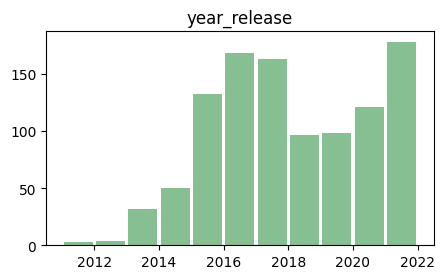

In [51]:
%matplotlib inline
playlists_df.hist(column='year_release', grid=False, figsize=(5,10),bins=11, layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

In the "year_release" graph for playlists and tracks, release rates have peaked in between 2016-2018 and 2022.
This is really important in 2016, a lot of young artists gained popularity in that time, eg. Lorde, Avicii, Alan Walker (these people might not be in the data, but it is from my personal experience and opinion)

Then, we plot the release year of all tracks from 2007 to now, because the data from the year that lower than 2007 is too small to plot.

array([[<AxesSubplot: title={'center': 'year_release'}>, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

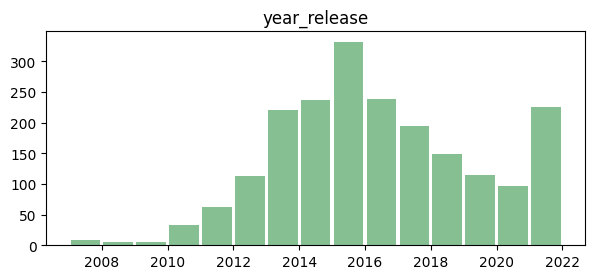

In [52]:
%matplotlib inline
tracks_df.hist(column='year_release', range=[2007, 2022], bins=15, grid=False, figsize=(16,10), layout=(3,2), sharex=True, color='#86bf91', rwidth=0.9)

In the graph for tracks, as the years went, the release rate seems to decrease overtime until in 2022 when many Gen-Z artists underwent a surge in popularity, mainly after the pandemic has alleviated in terms of intensity
As for playlists graph, it shared a similar reduction after 2018 but slowly recovered after that.

In overall, from 2 graphs, we can conclude that Soundcloud is still popular with musicians and listeners despite a little bit drop from 2018 to 2021.

### Expedition 4:

We do see the like also effect the viral of the uploaded music, we will check the effect of likes on the music play or not?

We perform a linear regression model and a interative graph between number of likes and played.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tracks_df_sum['total_plays'].values.reshape(-1, 1), tracks_df_sum['likes'].values, test_size=0.2, random_state=10) 

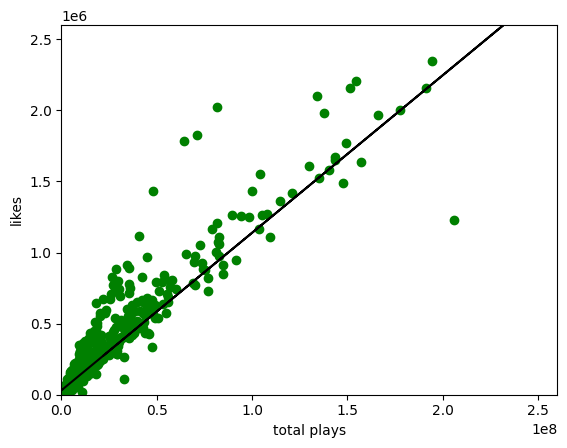

In [55]:
%matplotlib inline
regressor = LinearRegression() 
regressor.fit(X_train, y_train) 

y_pred = regressor.predict(X_test)
plt.xlim([0, 260000000])
plt.ylim([0, 2600000])
plt.xlabel('total plays')
plt.ylabel('likes')
plt.scatter(X_train, y_train,color='g') 
plt.plot(X_test, y_pred,color='k') 

plt.show()

As the graph above, the number of likes and total plays has a linear combination. The more played on a track, the more likes that track will be received.

### Expedition 5:

Do the songs with 10 million plays come from users with the number of followers above the mean value, which is about 178 thousand followers?

We get the number of tracks with more than 10 million plays and in that tracks, filter the tracks with above 178 thousand followers.

In [56]:
new_data_sorted = new_data[new_data['total_plays'] >= 10000000]
new_data_sorted_followers = new_data_sorted[new_data_sorted['followers'] >= 178000]
print("Number of tracks with more than 10 million plays: ", len(new_data_sorted))
print("Number of tracks with more than 10 million plays and author have above 178 thousand followers: ", len(new_data_sorted_followers))

Number of tracks with more than 10 million plays:  29
Number of tracks with more than 10 million plays and author have above 178 thousand followers:  29


We can see that all the tracks that have more than 10 million plays come from the user with more than 178 thousand followers 

### Expedition 6:

So what kind of vibe music titles that the users on SoundCloud usually listen to? Positive vibe or Negative vibe?

To know that which title is positive or negative, we need a machine learning model to classify the title.

Here we use the distilBERT for English text from hugging face.

Run the model for all data

In [58]:
classifier = pipeline("text-classification", model = "distilbert-base-uncased-finetuned-sst-2-english")
new_data['title_sentiment'] = new_data.apply(lambda row: classifier(row['track_title'])[0]['label'], axis = 1);

2022-12-05 21:06:49.684468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 21:06:49.787947: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 21:06:49.809748: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-05 21:06:50.246638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Calculate the percentage of each type (positive and negative)

In [59]:
new_data['title_sentiment']
aggregation_functions = {'total_plays': 'sum', 'track_like': 'sum', 'track_repost': 'sum'}
new_data_sentiment = new_data.groupby(new_data['title_sentiment']).aggregate(aggregation_functions)

new_data_sentiment['play_percent'] = (new_data_sentiment['total_plays'] / new_data_sentiment['total_plays'].sum()) * 100
new_data_sentiment['like_percent'] = (new_data_sentiment['track_like'] / new_data_sentiment['track_like'].sum()) * 100
new_data_sentiment['repost_percent'] = (new_data_sentiment['track_repost'] / new_data_sentiment['track_repost'].sum()) * 100

# Visualization

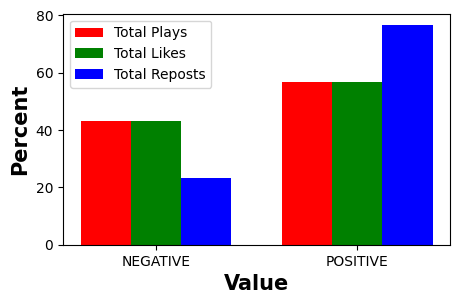

In [60]:
%matplotlib inline
fig = plt.subplots(figsize =(5, 3))

barWidth =0.25
br1 = np.arange(len(new_data_sentiment.index))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, new_data_sentiment['play_percent'], width = barWidth, color ='r', label='Total Plays')
plt.bar(br2, new_data_sentiment['like_percent'], width = barWidth, color ='g', label='Total Likes')
plt.bar(br3, new_data_sentiment['repost_percent'], width = barWidth, color ='b', label='Total Reposts')

plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Percent', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(new_data_sentiment.index))],
        list(new_data_sentiment.index))


plt.legend()
plt.show()

It is clear that all criterias in the "negative" are all lower than those of "positive".

The gap in "total likes" and "total plays" between "negative" and "positive" is small and similar whilst the "reposts" is a significant one. The "reposts" rate in the right side outnumbered the left side.

This could be due to the habit of SoundCloud users where they usually share/repost tracks from small and minor artists they've been following, not the big ones. Small artists tend to publish their tracks without thinking who would listen to them.